In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)



# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
predict_day = 5
learning_rate = 0.01
iterations = 500
LSTM_stack = 2


# Choose stock
stock = "KRX:001380"
pred_label = 3 # 0 : Open, 1: High 2: Low, 3:Close 4:Volumne

# data scrolling parts
from pandas import DataFrame
from pandas_datareader import data, wb
from datetime import datetime

# 날짜 지정
now=datetime.now()
year = now.year
month = now.month
day = now.day

start = datetime(2016, 1, 2)
end = datetime(year, month, day)
df = data.DataReader(
    stock,  # name
    "google",  # data source
    start,  # start
    end  # end
)



In [2]:
# Convert pandas dataframe to numpy array
dataset_temp = df.as_matrix()
#dataset_temp = dataset_temp[:-1,:]



In [3]:
# Open, High, Low, Volume, Close
test_min = np.min(dataset_temp, 0)
test_max = np.max(dataset_temp, 0)
test_denom = test_max - test_min

dataset = MinMaxScaler(dataset_temp)


In [4]:

dataset_temp = df.as_matrix()
test_last_X = (dataset_temp[-seq_length:,:]-test_min)/(test_denom+1e-7);



In [5]:
# build a dataset
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length-predict_day+1):
    _x = dataset[i:i + seq_length]
    #_y = dataset_label[i + seq_length]  # Next close price
    _y = dataset[i + predict_day:i + seq_length+predict_day]
    dataX.append(_x)
    dataY.append(_y)
    

# train/test split 70 / 30
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])



In [6]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_X')
#Y = tf.placeholder(tf.float32, [None, seq_length], name='intput_Y')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

#X_one_hot = tf.one_hot(X, data_dim)
# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
    return cell

multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs_rnn, _states=tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

In [7]:
X_for_fc = tf.reshape(outputs_rnn, [-1, hidden_dim])
Y_pred_temp = tf.contrib.layers.fully_connected(X_for_fc, output_dim, activation_fn=None)  
# reshape out for sequence_loss
Y_pred = tf.reshape(Y_pred_temp, [-1, seq_length])

"""
#FC layer

Y_pred_1 = tf.contrib.layers.fully_connected(outputs_rnn[:, 0], output_dim, activation_fn=None)  
Y_pred_2 = tf.contrib.layers.fully_connected(outputs_rnn[:, 1], output_dim, activation_fn=None)  
Y_pred_3 = tf.contrib.layers.fully_connected(outputs_rnn[:, 2], output_dim, activation_fn=None)  
Y_pred_4 = tf.contrib.layers.fully_connected(outputs_rnn[:, 3], output_dim, activation_fn=None)  
Y_pred_5 = tf.contrib.layers.fully_connected(outputs_rnn[:, 4], output_dim, activation_fn=None)  
Y_pred_6 = tf.contrib.layers.fully_connected(outputs_rnn[:, 5], output_dim, activation_fn=None)  
Y_pred_7 = tf.contrib.layers.fully_connected(outputs_rnn[:, 6], output_dim, activation_fn=None)  

Y_pred= tf.concat([Y_pred_1, Y_pred_2,Y_pred_3,Y_pred_4,Y_pred_5,Y_pred_6,Y_pred_7], 1)
"""


'\n#FC layer\n\nY_pred_1 = tf.contrib.layers.fully_connected(outputs_rnn[:, 0], output_dim, activation_fn=None)  \nY_pred_2 = tf.contrib.layers.fully_connected(outputs_rnn[:, 1], output_dim, activation_fn=None)  \nY_pred_3 = tf.contrib.layers.fully_connected(outputs_rnn[:, 2], output_dim, activation_fn=None)  \nY_pred_4 = tf.contrib.layers.fully_connected(outputs_rnn[:, 3], output_dim, activation_fn=None)  \nY_pred_5 = tf.contrib.layers.fully_connected(outputs_rnn[:, 4], output_dim, activation_fn=None)  \nY_pred_6 = tf.contrib.layers.fully_connected(outputs_rnn[:, 5], output_dim, activation_fn=None)  \nY_pred_7 = tf.contrib.layers.fully_connected(outputs_rnn[:, 6], output_dim, activation_fn=None)  \n\nY_pred= tf.concat([Y_pred_1, Y_pred_2,Y_pred_3,Y_pred_4,Y_pred_5,Y_pred_6,Y_pred_7], 1)\n'

In [8]:
# cost/loss
mean_loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

trainY_label=trainY[:,[-1], pred_label]
testY_label=testY[:,[-1], pred_label]

In [9]:
testY.shape

(111, 7, 5)

In [10]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)
    
    losslist = [];
    # Training step
    for i in range(iterations):
    
        _, step_loss = sess.run([optimizer, mean_loss], 
                                        feed_dict={X: trainX, 
                                                   Y: trainY_label})
        losslist = np.append(losslist, step_loss)
        


    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X.reshape(1, seq_length, data_dim)})
   

In [11]:
print("predictions ", end='')
print(prediction_test *test_denom[pred_label]+test_min[pred_label])


predictions [[ 4259.96386719  4210.09570312  4534.03808594  4863.04101562
   4835.53710938  4962.59814453  4991.18457031]]


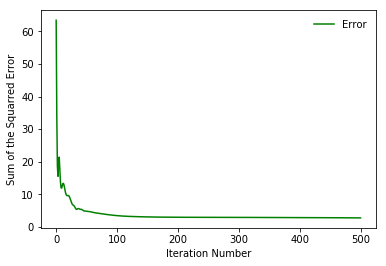

In [12]:
# Plot losss
plt.figure(1)
plt.plot(losslist, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

plt.show()

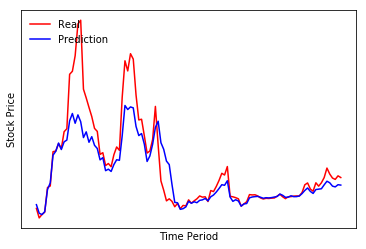

In [13]:
# Plot predictions
plt.figure(2)
testY_plt=testY[:,[0],[pred_label]]*test_denom[pred_label]+test_min[pred_label]
test_predict_plt=test_predict[:, 5]*test_denom[pred_label]+test_min[pred_label]
plt.plot(testY_plt, color="red", label="Real")
plt.plot(test_predict_plt, color="blue", label="Prediction")
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(loc='upper left', frameon=False)
plt.xticks([])
plt.yticks([])

plt.show()

In [14]:
print((testY_plt-test_predict_plt).max())
print((testY_plt-test_predict_plt).min())
print((testY_plt-test_predict_plt).mean())

5751.21313467
-3327.07666017
243.282565242


In [15]:
testY_plt

array([[ 3529.99999998],
       [ 3249.99999998],
       [ 3349.99999998],
       [ 3419.99999998],
       [ 4149.99999997],
       [ 4194.99999997],
       [ 5209.99999996],
       [ 5229.99999996],
       [ 5449.99999995],
       [ 5299.99999995],
       [ 5799.99999995],
       [ 5889.99999995],
       [ 7499.99999992],
       [ 7589.99999992],
       [ 8049.99999991],
       [ 8989.9999999 ],
       [ 9099.9999999 ],
       [ 7059.99999993],
       [ 6799.99999993],
       [ 6519.99999994],
       [ 6249.99999994],
       [ 5899.99999995],
       [ 5809.99999995],
       [ 5129.99999996],
       [ 5179.99999996],
       [ 4799.99999996],
       [ 4859.99999996],
       [ 4764.99999996],
       [ 5119.99999996],
       [ 5349.99999995],
       [ 5249.99999995],
       [ 6819.99999993],
       [ 7899.99999992],
       [ 7599.99999992],
       [ 8109.99999991],
       [ 7949.99999992],
       [ 6889.99999993],
       [ 6149.99999994],
       [ 6169.99999994],
       [ 5679.99999995],


In [16]:
predict=DataFrame(test_predict*test_denom[pred_label]+test_min[pred_label])
for i in range(1,seq_length):
    predict.ix[:,i]=predict.ix[:,i].shift(i)
predict


,0,1,2,3,4,5,6
0,3558.695801,NaN,NaN,NaN,NaN,NaN,NaN
1,3526.352783,3545.712158,NaN,NaN,NaN,NaN,NaN
2,3567.821289,3592.411133,3598.391602,NaN,NaN,NaN,NaN
3,3563.260254,3577.775391,3586.482422,3592.879883,NaN,NaN,NaN
4,3612.600098,3637.263916,3643.614502,3661.096436,3673.239502,NaN,NaN
5,3597.615723,3592.774902,3607.282715,3616.933105,3637.512939,3642.031982,NaN
6,3374.145508,3369.777344,3353.710449,3367.425781,3377.550293,3388.333740,3383.594971
7,3322.144775,3352.825195,3323.339111,3322.175293,3343.227539,3348.786865,3353.762939
8,3420.109375,3445.810059,3446.776367,3420.260742,3422.994385,3434.978516,3432.022949
9,3885.593262,3954.358398,3998.844482,4042.178223,4066.993652,4088.888916,4109.465332


In [17]:
predict.mean(axis =1).shape
predict.shape[0]

111

In [18]:
A=train_size+seq_length+1-predict_day
df_result=df.ix[A:A+predict.shape[0],:]



In [19]:
A=predict.mean(axis =1).values

df_result["Predict Close"]=A.round() 


C:\Users\smrks\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [20]:
df_result

,Open,High,Low,Close,Volume,Predict Close
Date,,,,,,
2017-01-19,3520.0,3615.0,3485.0,3535.0,88520,3559.0
2017-01-20,3530.0,3735.0,3480.0,3735.0,271220,3536.0
2017-01-23,3830.0,3830.0,3520.0,3530.0,635052,3586.0
2017-01-24,3495.0,3495.0,3215.0,3250.0,270839,3580.0
2017-01-25,3215.0,3350.0,3140.0,3350.0,139397,3646.0
2017-01-26,3370.0,3425.0,3290.0,3420.0,83358,3616.0
2017-01-31,3760.0,4370.0,3720.0,4150.0,6506516,3374.0
2017-02-01,4270.0,4305.0,3985.0,4195.0,2642542,3338.0
2017-02-02,4375.0,5450.0,4350.0,5210.0,7154534,3432.0


In [21]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,2605.0,2655.0,2485.0,2500.0,134124
2016-01-05,2500.0,2590.0,2475.0,2495.0,100312
2016-01-06,2500.0,2680.0,2475.0,2570.0,193111
2016-01-07,2570.0,2595.0,2470.0,2490.0,90929
2016-01-08,2425.0,2465.0,2340.0,2440.0,83189
2016-01-11,2400.0,2560.0,2400.0,2525.0,84799
2016-01-12,2510.0,2580.0,2470.0,2535.0,79694
2016-01-13,2585.0,2585.0,2515.0,2560.0,81592
2016-01-14,2490.0,2660.0,2480.0,2570.0,154941
